In [57]:
##Visualise some 2-3 objects in the dataset along with keypoint annotations

In [58]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [59]:
MIN_KEYPOINTS = 5
DATASET_LENGTH = 1000

# COCO skeleton pairs (converted to 0-indexed)
SKELETON = [
    [15, 13], [13, 11], [16, 14], [14, 12], [11, 12],     #Connecting lower body keypoints
    [5, 11], [6, 12], [5, 6],                             #Connecting middle body keypoints
    [5, 7], [6, 8], [7, 9], [8, 10],                      #Connecting hands' related keypoints
]

# Loading the dataset

In [60]:
with open('/kaggle/input/coco2017/annotations/person_keypoints_train2017.json') as f:
    coco_data = json.load(f)

# Find out valid images that have keypoint annotations

In [61]:
#Find out valid images that have keypoint annotations
valid_anns = []
for annotation in coco_data['annotations']:
    if annotation['num_keypoints'] > MIN_KEYPOINTS:
        valid_anns.append(annotation)

#Finding image corresponding to annotation using image id
imgid_to_filename_dict = {img['id']: img['file_name'] for img in coco_data['images']}
imgid_to_skeleton_dict = {}

# Helper functions to extract keypoints, draw keypoints and draw skeletons

In [62]:
def extract_keypoints(annotation):
    return np.array(annotation['keypoints']).reshape(-1, 3)

def draw_skeleton(image, kpts):
    overlay = image.copy()
    for i, j in SKELETON:
        if kpts[i, 2] > 0 and kpts[j, 2] > 0:
            pt1 = (int(kpts[i, 0]), int(kpts[i, 1]))
            pt2 = (int(kpts[j, 0]), int(kpts[j, 1]))
            cv2.line(overlay, pt1, pt2, (0, 255, 0), 3)
    return overlay

def draw_keypoints(image, kpts, SKELETON):  #DRAW ONLY THOSE KEYPOINTS THAT ARE PART OF SKELETON
    keypoint_img = np.zeros_like(image)
    
    # Flatten skeleton to get all keypoint indices that participate
    skeleton_indices = set([i for pair in SKELETON for i in pair])
    
    for idx, (x, y, v) in enumerate(kpts):
        if v > 0 and idx in skeleton_indices:
            cv2.circle(keypoint_img, (int(x), int(y)), 5, (255, 0, 0), -1)
    
    return keypoint_img


def visualize_sample(original, overlay, img_id, num_kpts):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(original)
    axes[0].set_title(f"Original (ID: {img_id})")
    axes[0].axis('off')

    axes[1].imshow(overlay)
    axes[1].set_title(f"Keypoints ({num_kpts})")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

def add_skeleton_information(imgid_to_skeleton_dict, valid_anns, imgid_to_filename_dict):
    for i in range(DATASET_LENGTH):
        ann = valid_anns[i]
        img_id = ann['image_id']
        filename = imgid_to_filename_dict[img_id]
        
        img_path = f'/kaggle/input/coco2017/train2017/{filename}'
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        kpts = extract_keypoints(ann)
        overlay = draw_keypoints(img, kpts, SKELETON)
        overlay = draw_skeleton(overlay, kpts)
    
        if img_id not in imgid_to_skeleton_dict:
            imgid_to_skeleton_dict[img_id] = []
        imgid_to_skeleton_dict[img_id].append(overlay)
    

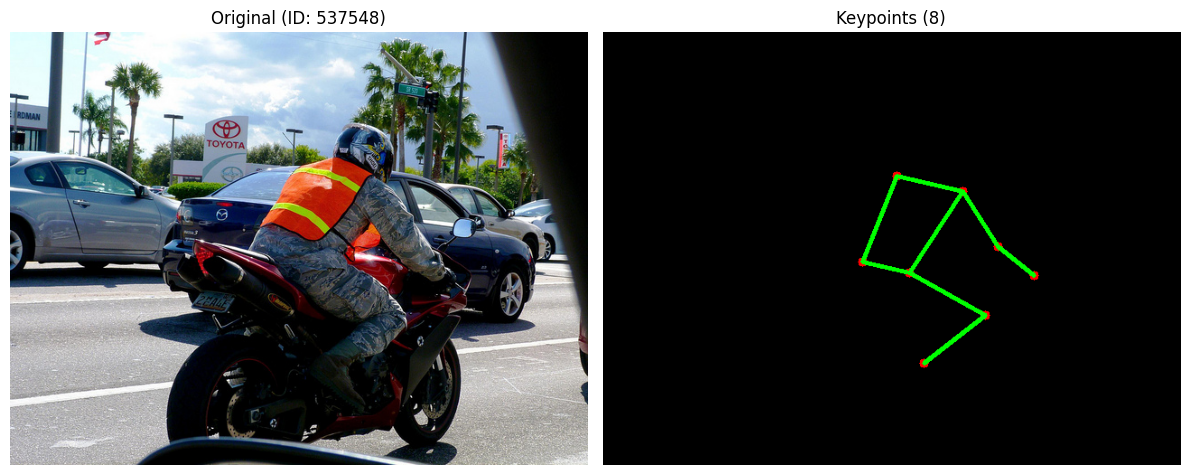

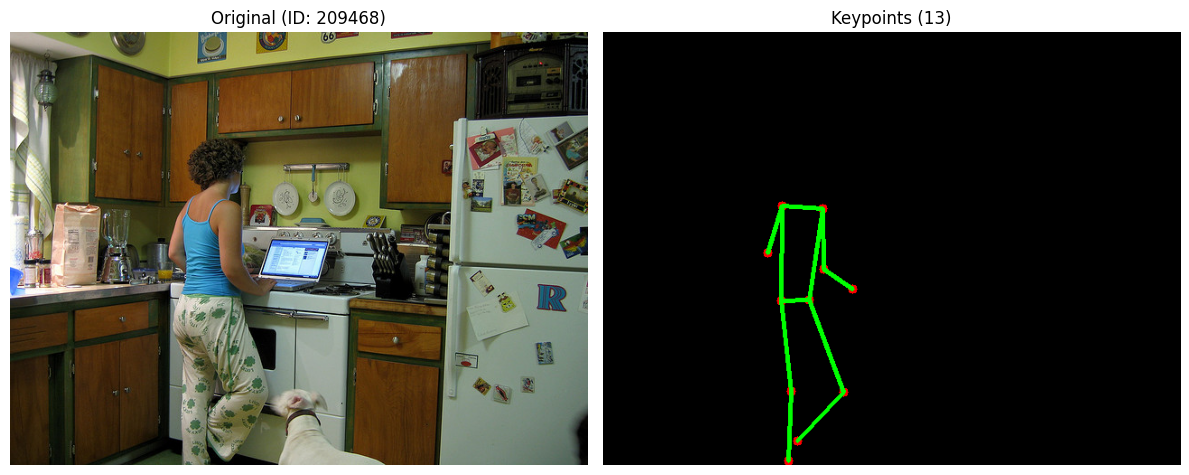

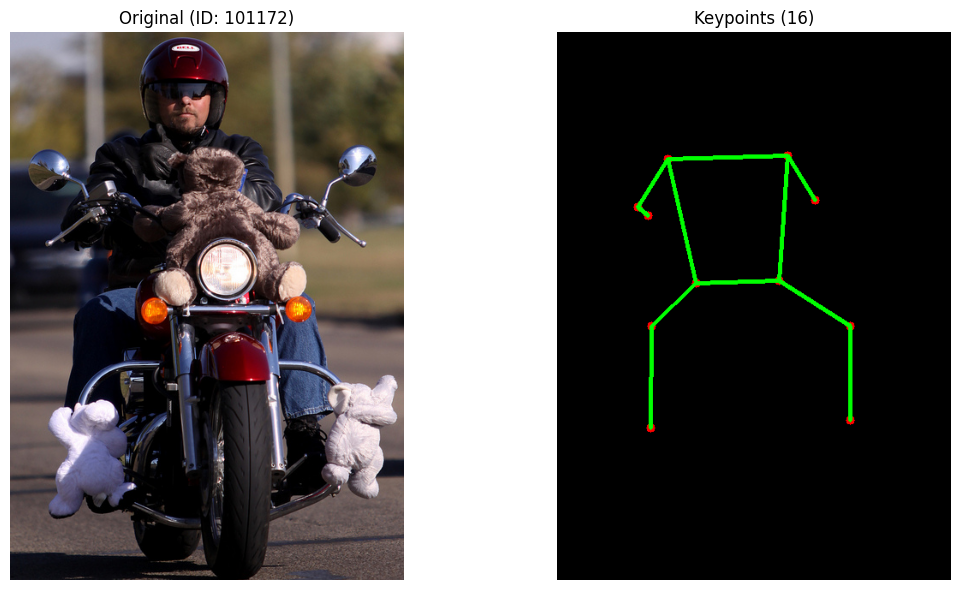

In [63]:
#Overlay the keypoints on these images and display them (#Rendering this image for visualisation)
for i in range(3):
    ann = valid_anns[i]
    img_id = ann['image_id']
    filename = imgid_to_filename_dict[img_id]
    
    img_path = f'/kaggle/input/coco2017/train2017/{filename}'
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    
    kpts = extract_keypoints(ann)
    # overlay = draw_skeleton(img, kpts)
    # overlay = draw_keypoints(overlay, kpts)
    overlay = draw_keypoints(img, kpts, SKELETON)
    # plt.imshow(overlay)
    overlay = draw_skeleton(overlay, kpts)

    if img_id not in imgid_to_skeleton_dict:
        imgid_to_skeleton_dict[img_id] = []
    imgid_to_skeleton_dict[img_id].append(overlay)
    # plt.imshow(overlay)
    
    visualize_sample(img, overlay, img_id, ann['num_keypoints'])


# Dataset creation logic

## Extract skeleton for every image

In [64]:
add_skeleton_information(imgid_to_skeleton_dict, valid_anns, imgid_to_filename_dict)

In [65]:
len(imgid_to_skeleton_dict)  #CONT FROM HERE

96

## Extract captions for every image

In [66]:
#For every valid image, find appropriate caption using image_id

with open('/kaggle/input/coco2017/annotations/captions_train2017.json') as f:
    captions_data = json.load(f)

# Create caption lookup (image_id -> list of captions)
img_to_captions_dict = {}
for cap in captions_data['annotations']:
    img_id = cap['image_id']
    if img_id not in img_to_captions_dict:
        img_to_captions_dict[img_id] = []   #Add a new img_id to dictionary
    img_to_captions_dict[img_id].append(cap['caption'])  #Add captions corresponding to new image

len(img_to_captions_dict)

118287

In [67]:
print(len(valid_anns))
print(len(imgid_to_filename_dict))
print(len(img_to_captions_dict))
print(len(imgid_to_skeleton_dict))

129762
118287
118287
96


## Actual Dataset creation loop

In [68]:
#Save the images, poses and text captions in a dictionary
# [{'image_id': , 'img': , text prompt': , 'skeleton': } for _ in _]

# Create combined dataset
dataset = []

for ann in valid_anns:
    img_id = ann['image_id']
    
    # Check if we have all required data
    if img_id in imgid_to_filename_dict and img_id in img_to_captions_dict and img_id in imgid_to_skeleton_dict:
        # Pick first caption (or random.choice if you want variety)
        caption = img_to_captions_dict[img_id][0]

        img_id = ann['image_id']
        filename = imgid_to_filename_dict[img_id]
        img_path = f'/kaggle/input/coco2017/train2017/{filename}'
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        dataset.append({
            'image_id': img_id,
            'img': img,
            'text_prompt': caption,
            'skeleton': imgid_to_skeleton_dict[img_id][0]
        })

print(f"Combined dataset size: {len(dataset)}")



Combined dataset size: 203


484279
two men standing between  a blue motorcycle and a wall 


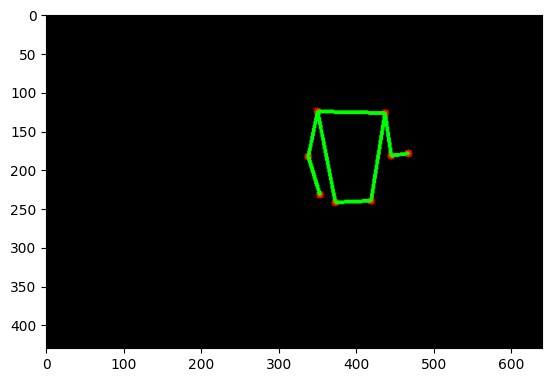

In [77]:
print(dataset[100]['image_id'])
# plt.imshow(dataset[100]['img'])
print(dataset[100]['text_prompt'])
plt.imshow(dataset[100]['skeleton'])

# Store in some output format from which I can load quickly and start working

In [70]:
import pickle

with open("coco_pose_dataset.pkl", "wb") as f:
    pickle.dump(dataset, f)